### Predict if two quora questions are same
- This is a Kaggle problem, to test our models we use labelled data. 
- I divide the labelled data into training and test.
- I judge the models on accuracy on test data.
#### Summary
- I first use a bow model.
- I combine two questions into one column.
- I tokenize the combined column.
- I numericalize the combined column using TFIDF. The result of TFIDF is our input to the models.
- When I use logistic regresion for this classification problem I obtain score 0.796 in about 60 s.
- When I Standardize the features I see that training slows down and did not converge till 2500 iterations in about 25 minute.
- When I use NaiveBayes Logistic regression we obtain accurace score 0.796 in about 9 minute.
- When I use Xgboost we obtain accurace score 0.793 in about 9 minute.
- I tried  Gaussian Naive Bayes and Support vector machine. Using a small subset of data I find traing is slow so did not move forward with these models. 

In [1]:
import pandas as pd
import numpy as np
import re, string
# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df = df.drop(['qid1','qid2','id'],axis=1)

In [5]:
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404289 non-null  object
 1   question2     404288 non-null  object
 2   is_duplicate  404290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


####  Our goal is to predict is_duplicate column based on text data in question1 and question2

In [7]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

#### We will combine question1 and question2 coulmns and use the resultant column as our feature for the model

In [8]:
df['text'] = df['question1'].astype(str)+df['question2'].astype(str)

In [9]:
df.head()

,question1,question2,is_duplicate,text
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt..."


### Use TFIDF to get numerical features from text data

In [98]:
n = df.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X = vec.fit_transform(df["text"])
y = df["is_duplicate"]

In [99]:
X.shape, y.shape

((404290, 338674), (404290,))

### Split data into  test and train 

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### LogisticRegression 

In [101]:
from sklearn.linear_model import LogisticRegression
%time clf = LogisticRegression(random_state=0,max_iter=1500,C=1,solver='saga',n_jobs=-1,penalty='l2')
%time clf.fit(X_train, y_train)
print('train score',clf.score(X_train, y_train))
print('test score', clf.score(X_test,y_test))

CPU times: user 53 µs, sys: 159 µs, total: 212 µs
Wall time: 216 µs
CPU times: user 12.7 s, sys: 111 ms, total: 12.8 s
Wall time: 13.1 s
train score 0.8439027148122105
test score 0.7962930899436873


### Standardize data and see if it effects the results

In [17]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False) # Need to have with_mean False for sparse data
X_scaled = scalar.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

In [21]:
%time clf = LogisticRegression(random_state=0,max_iter=2500,C=1000,solver='saga',n_jobs=-1,penalty='l2')
%time clf.fit(X_train, y_train)
print('train score',clf.score(X_train, y_train))
print('test score', clf.score(X_test,y_test))

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 24.8 µs
CPU times: user 22min 59s, sys: 4.92 s, total: 23min 3s
Wall time: 23min 23s
train score 0.9942120754903658
test score 0.7745265362322425


/Applications/anaconda3/envs/nlp-thakur/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


- This slows down training. So going forward I am not going to use it.

### Ploting the learning curves 

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


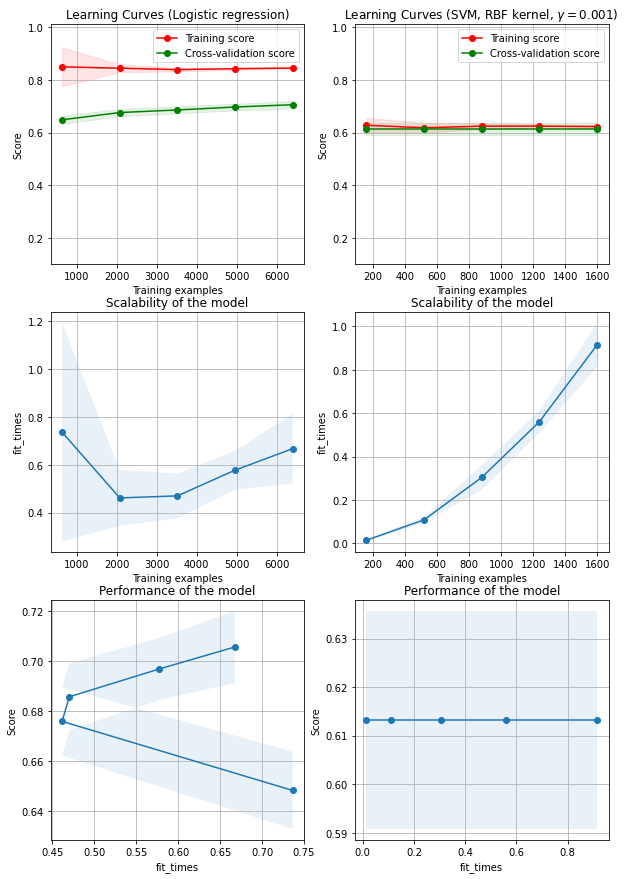

In [104]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves (Logistic regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = LogisticRegression(random_state=0,max_iter=1500,C=1,solver='saga',n_jobs=-1,penalty='l2')
plot_learning_curve(estimator, title, X_train[1:8000], y_train[1:8000], axes=axes[:, 0], ylim=(0.1, 1.01),
                    cv=cv, n_jobs=4)
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X_train[1:2000], y_train[1:2000], axes=axes[:, 1], ylim=(0.1, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

### NBLogisticRegression

In [16]:
def pr(y_i, y):
    p = X_train[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum())

In [17]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=False, max_iter=400)
    x_nb =(X_train.multiply(r))
    return m.fit(x_nb, y), r

In [18]:
#r = get_mdl(y_train)
#preds= m.predict_proba(x_test.multiply(r))

In [19]:
y = y_train.values
r = np.log(pr(1,y) / pr(0,y))
r.shape, X_train.shape 

((1, 338674), (283003, 338674))

In [20]:
x_nb =(X_train.multiply(r))
x_nb.shape, y_train.shape

((283003, 338674), (283003,))

In [21]:
m = LogisticRegression(random_state=0,max_iter=1500,C=100,solver='saga',n_jobs=-1,penalty='l2')
%time m.fit(x_nb,y_train)
print('train score',m.score(X_train.multiply(r), y_train))
print('test score', m.score(X_test.multiply(r),y_test))

CPU times: user 8min 43s, sys: 1.52 s, total: 8min 44s
Wall time: 8min 46s
train score 0.9413504450482857
test score 0.7959138242350787


In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [17]:
m_svm = SVC(gamma=0.001)
%time m_svm.fit(X_train[1:20000],y_train[1:20000])
print('train score',m_svm.score(X_train[1:20000], y_train[1:20000]))

CPU times: user 1min 25s, sys: 479 ms, total: 1min 26s
Wall time: 1min 27s
train score 0.6296814840742037
test score 0.6767676767676768


In [19]:
%time print('test score', m_svm.score(X_test[1:20000],y_test[1:20000]))

test score 0.6302815140757038
CPU times: user 1min 10s, sys: 420 ms, total: 1min 11s
Wall time: 1min 12s


In [23]:
m_gm = GaussianNB()
%time m_gm.fit(X_train[1:2000].toarray(),y_train[1:2000])
%time print('train score',m_gm.score(X_train[1:2000].toarray(),y_train[1:2000]))
%time print('test score', m_gm.score(X_test[1:2000].toarray(),y_test[1:2000]))

CPU times: user 15.3 s, sys: 14.4 s, total: 29.7 s
Wall time: 34.5 s
train score 0.9984992496248124
CPU times: user 13 s, sys: 14.6 s, total: 27.6 s
Wall time: 29.7 s
test score 0.6798399199599799
CPU times: user 12.9 s, sys: 14.1 s, total: 27 s
Wall time: 28.7 s


In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [97]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.7, subsample=0.8,
                    n_estimators=3000, max_depth=2,learning_rate=1)
%time bst = clf.fit(X_train, y_train)
# make prediction
print('-----')
%time preds_train = clf.predict(X_train)
%time preds_test = clf.predict(X_test)
print('-----')
print('train score', accuracy_score(y_train, preds_train))
print('test score', accuracy_score(y_test, preds_test))

CPU times: user 41min 43s, sys: 40.6 s, total: 42min 24s
Wall time: 42min 46s
-----
CPU times: user 14.8 s, sys: 181 ms, total: 15 s
Wall time: 15 s
CPU times: user 6.45 s, sys: 79.3 ms, total: 6.52 s
Wall time: 6.53 s
-----
train score 0.868231078822486
test score 0.7926983106186154
